# Creación del Dataset

## Introducción al Proyecto

La finalidad de este proyecto es generar imágenes realistas de portadas de libros en función a un género en particular. Para ello, utilizaremos una red neuronal generativa adversaria condicional (cGAN) y el dataset "Amazon Book Dataset".

## Librerías Necesarias

Para poder llevar a cabo la creación del dataset deberemos previamente importar las siguientes librerías:

In [1]:
import os
from typing import Optional, Callable
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader
import urllib.request
from zipfile import ZipFile

## Descarga del Dataset

El dataset que utilizaremos se llama "Amazon Book Dataset", el cual es un dataset que contiene 57.000 imágenes de portadas de libro cada una clasificada en uno de los 30 géneros literarios que comprende el dataset. Las imágenes son a color y con una resolución de

Este dataset ya ha sido descargado con posterioridad en un Drive. Lo que procederemos a hacer a continucación es descargar el dataset y sus .csv correspondientes en el sistema de archivos de Google Colab.

In [7]:
DATASET_ZIP_URL = "https://www.dropbox.com/scl/fi/buygp1u3dlvql1omlgii6/title30cat.zip?rlkey=emlr8c439whnexhezqjanlr19&st=58w2deja&dl=1"
# CSV_TEST_URL = "https://www.dropbox.com/scl/fi/5qgqwksr9rz510cqqyzip/book30-listing-test.csv?rlkey=xu6m7bfbp9noefc91difpzix7&st=pmbqqis8&dl=1"
# CSV_TRAIN_URL = "https://www.dropbox.com/scl/fi/b28fi1cd6k4vtaj0en1lu/book30-listing-train.csv?rlkey=dd4lrdkoleiedezjzx9ing1yb&st=jwcx2hys&dl=1"

# en caso de no tener los archivos CSV descomente las líneas superiores

DATASET_PATH = "./224x224"
CSV_TEST_PATH = "./book30-listing-test.csv"
CSV_TRAIN_PATH = "./book30-listing-train.csv"
ZIP_PATH = "./title30cat.zip"

if not os.path.exists(DATASET_PATH):
    urllib.request.urlretrieve(DATASET_ZIP_URL, ZIP_PATH)
    with ZipFile(ZIP_PATH, "r") as zip_ref:
        zip_ref.extractall(".")
    os.remove(ZIP_PATH)
    print("Dataset descargado y descomprimido exitosamente.")
else:
    print("El dataset ya está descargado.")

if not os.path.exists(CSV_TEST_PATH):
    urllib.request.urlretrieve(CSV_TEST_URL, CSV_TEST_PATH)
    print("CSV de prueba descargado exitosamente.")
else:
    print("El CSV de prueba ya está descargado.")

if not os.path.exists(CSV_TRAIN_PATH):
    urllib.request.urlretrieve(CSV_TRAIN_URL, CSV_TRAIN_PATH)
    print("CSV de entrenamiento descargado exitosamente.")
else:
    print("El CSV de entrenamiento ya está descargado.")

El dataset ya está descargado.
El CSV de prueba ya está descargado.
El CSV de entrenamiento ya está descargado.


## Creación del Dataset

Definimos la clase LibrosData para poder crear nuestro dataset. Esta clase recibe como parámetros la ruta donde se encuentra el csv de nuestro dataset, la ruta donde se encuentran las imágenes, y la transformación a aplicar a cada una de las imágenes.

In [3]:
class LibrosDataset(Dataset):
    def __init__(self, csv_path: str, images_dir: str):
        """
        Dataset para imágenes de portadas con etiquetas desde un CSV.

        Args:
            csv_path (str): Ruta al archivo CSV con columnas 'filename' y 'genre'.
            images_dir (str): Carpeta donde están las imágenes.
        """
        self.data = pd.read_csv(csv_path, delimiter=";")
        self.images_dir = images_dir
        self.transform = transforms.Compose([
            transforms.Resize((64, 64)), # 224??
            transforms.ToTensor(),
            ])

        # Crear un mapeo de género a índice y viceversa
        self.genres = sorted(self.data['Category'].unique())
        self.genre_to_idx = {genre: idx for idx, genre in enumerate(self.genres)}
        self.idx_to_genre = {idx: genre for genre, idx in self.genre_to_idx.items()}

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.images_dir, row['Filename'])
        label_idx = self.genre_to_idx[row['Category']]
        label_tensor = torch.tensor(label_idx, dtype=torch.long)

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        return image, label_tensor

Instanciamos los datasets de entrenamiento y prueba:

In [4]:
train_librosData = LibrosDataset(CSV_TRAIN_PATH, DATASET_PATH)
test_librosData = LibrosDataset(CSV_TEST_PATH, DATASET_PATH)

## Exploración de Datos

La función ` plot_images` definida a continuación nos permite visualizar las imágenes que contiene nuestro dataset junto con el género al que pertenece:



In [5]:
def plot_images(dataset, indexes):
    fig, axs = plt.subplots(1, len(indexes), figsize=(len(indexes) * 5, 5))
    for i, idx in enumerate(indexes):
        img, genre_idx = dataset[idx]
        img = img.permute(1, 2, 0)
        # img = (img + 1) / 2
        axs[i].imshow(img)
        axs[i].set_title(f"Genre: {dataset.genres[genre_idx]}")
        axs[i].axis("off")
    plt.show()

Mostramos algunas imágenes de nuestro dataset de entrenamiento:

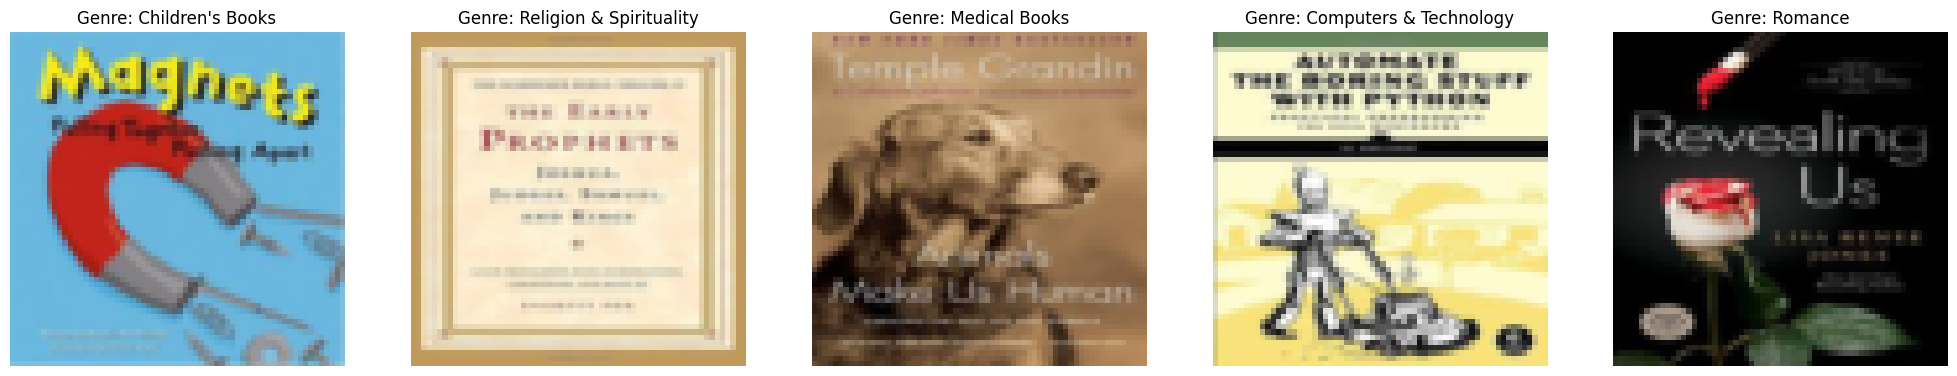

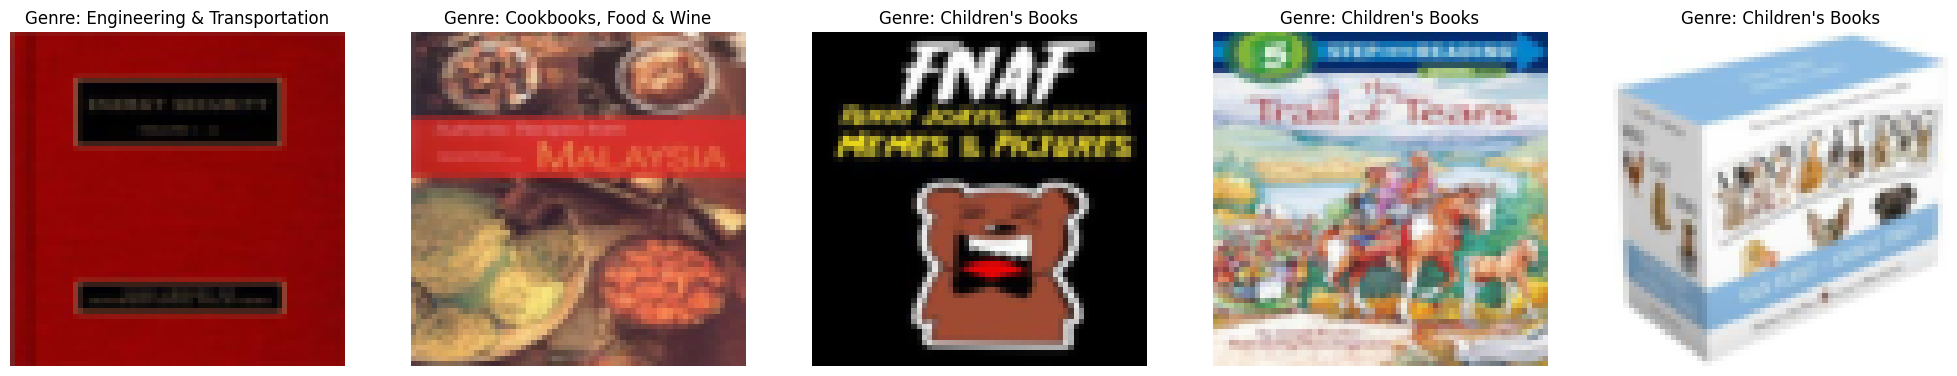

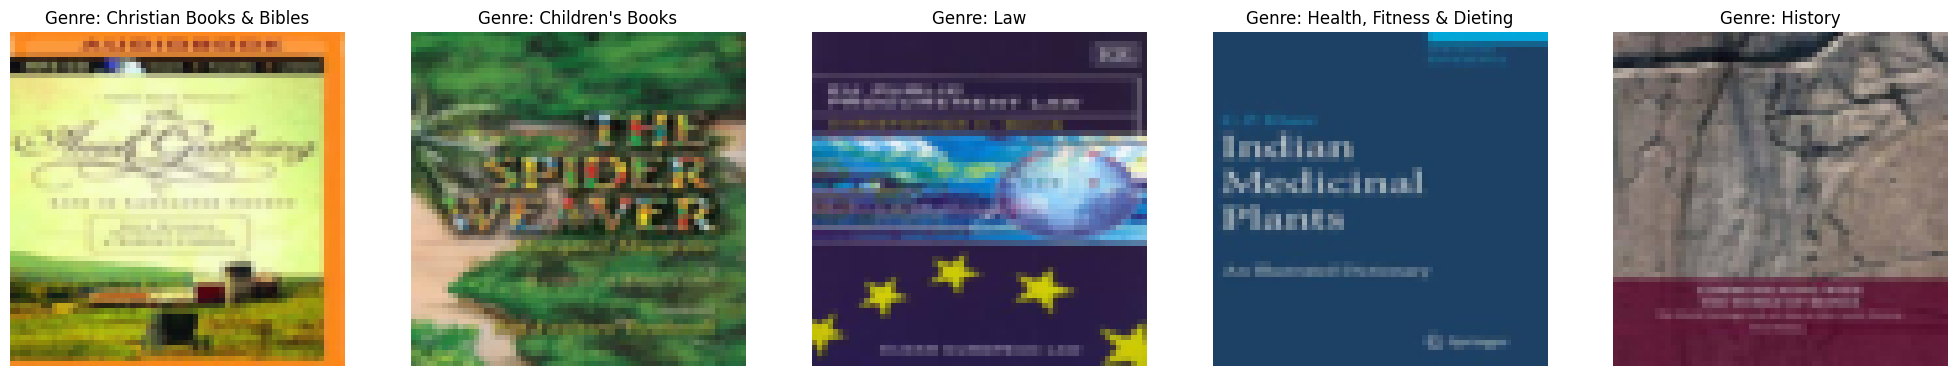

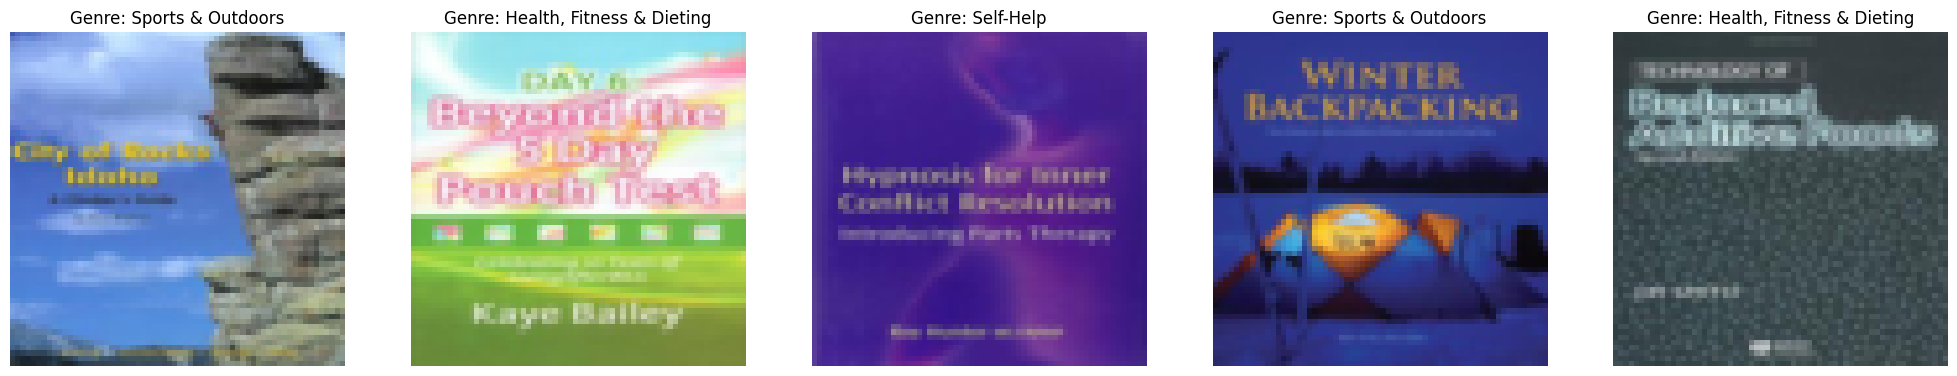

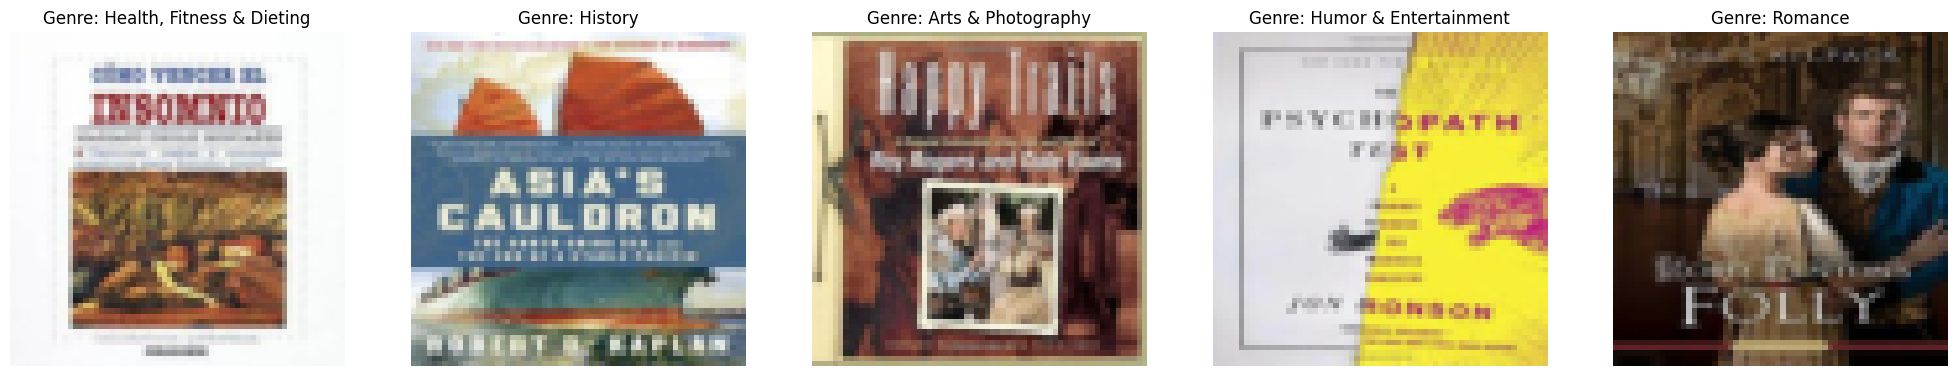

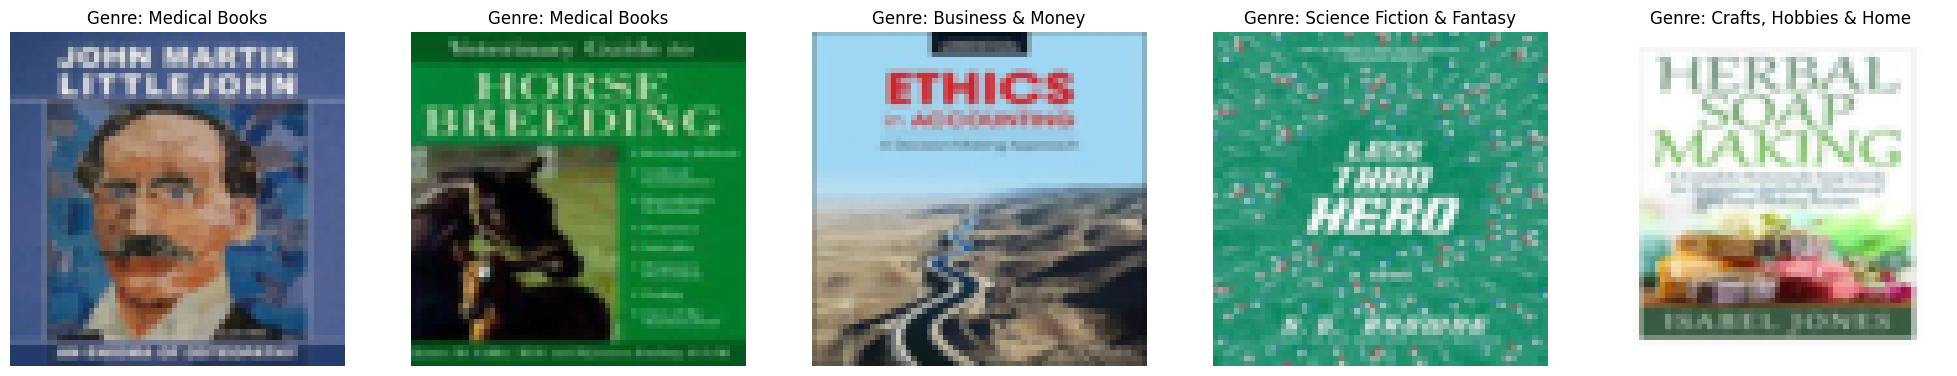

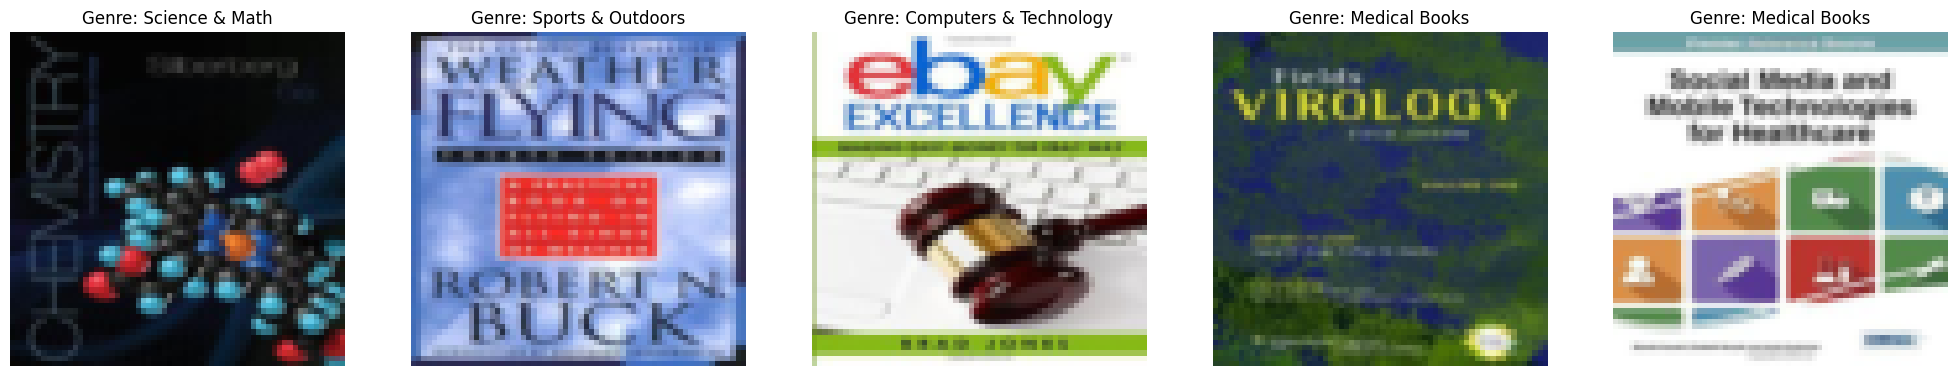

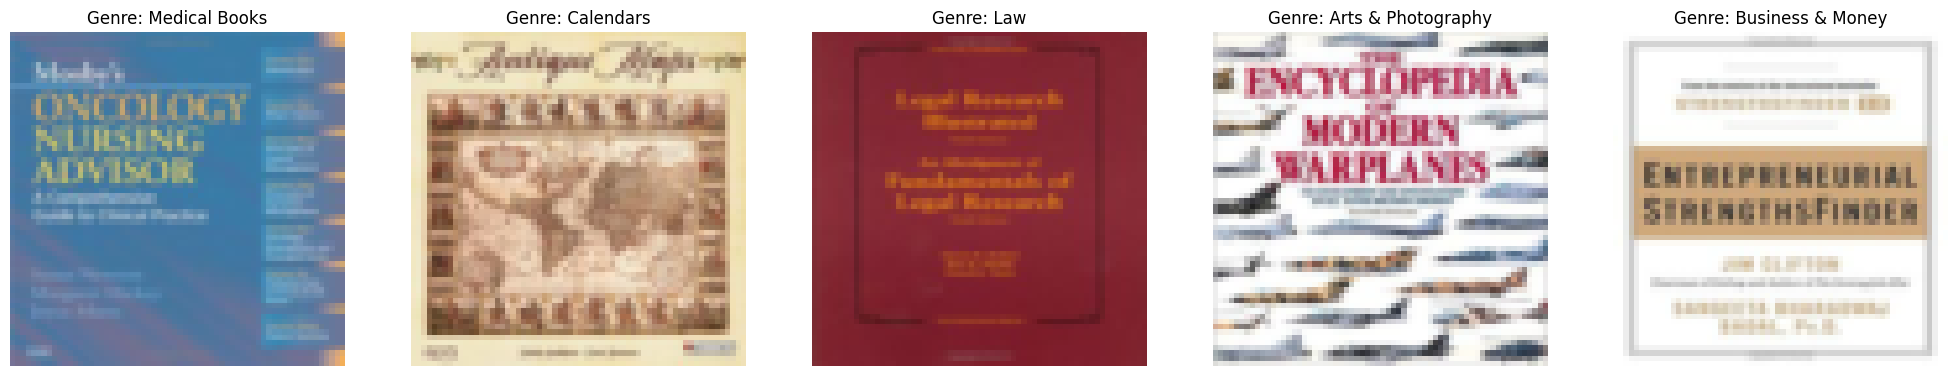

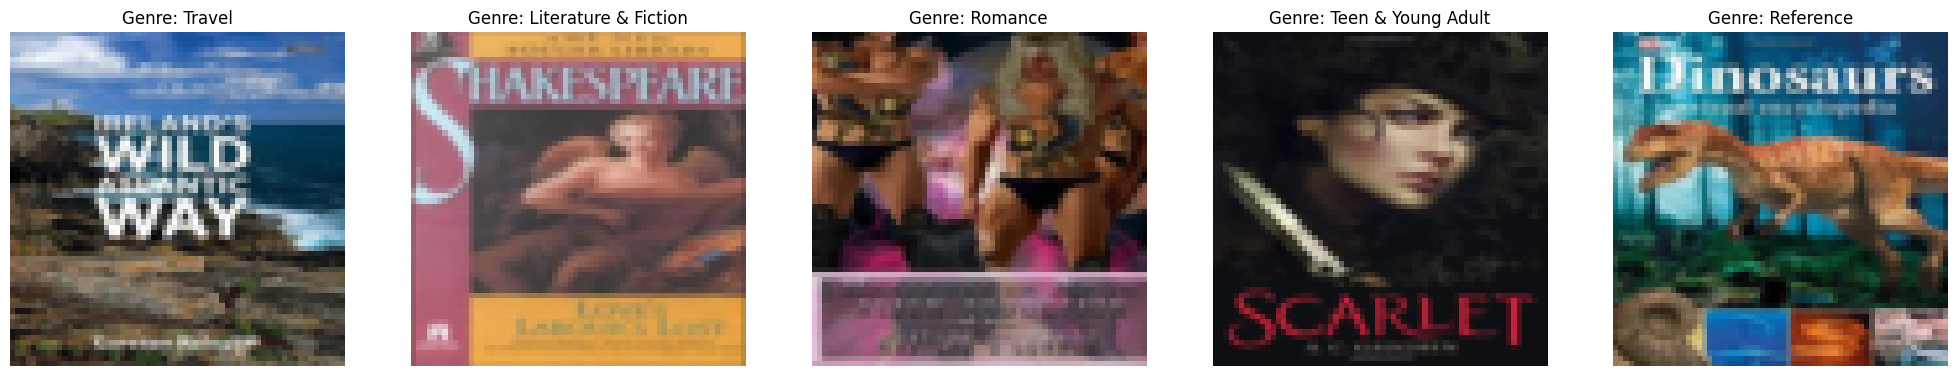

In [ ]:
for i in range(1, 10):
    plot_images(train_librosData, indexes=[1*i, 101*i, 201*i, 301*i, 401*i])

Y hacemos lo mismo para nuestro dataset de prueba:

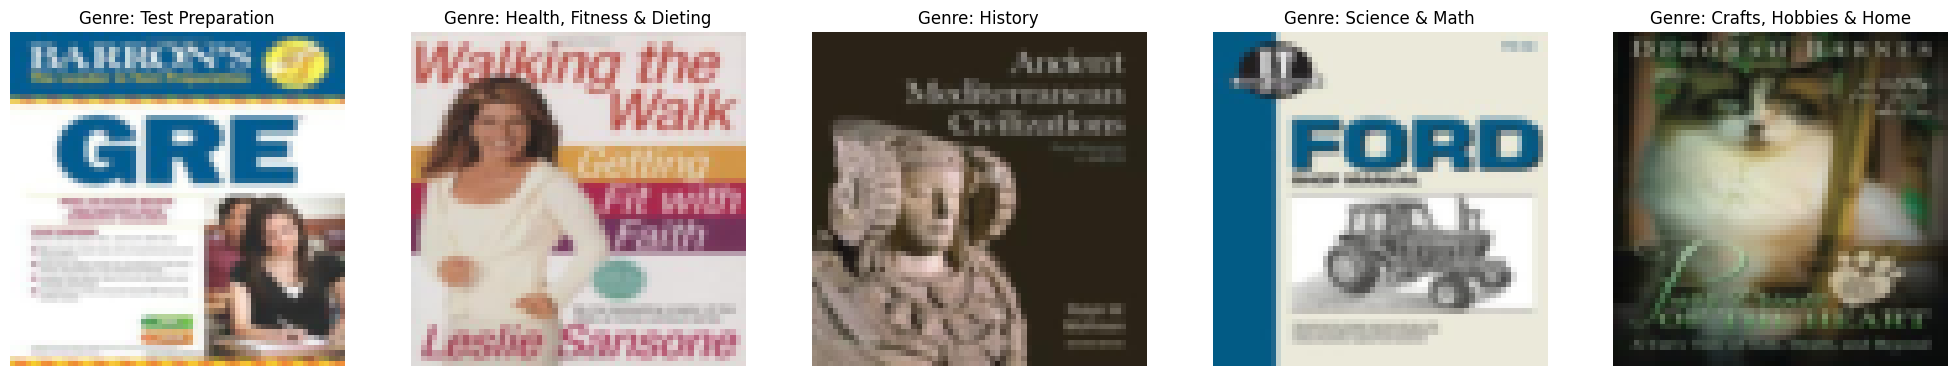

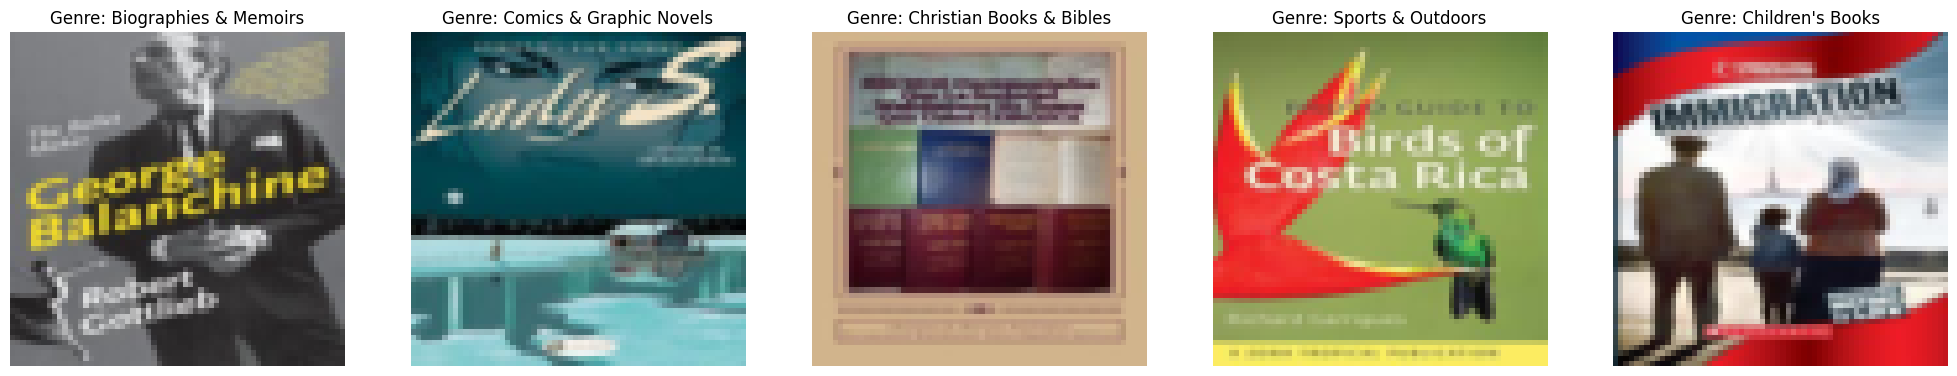

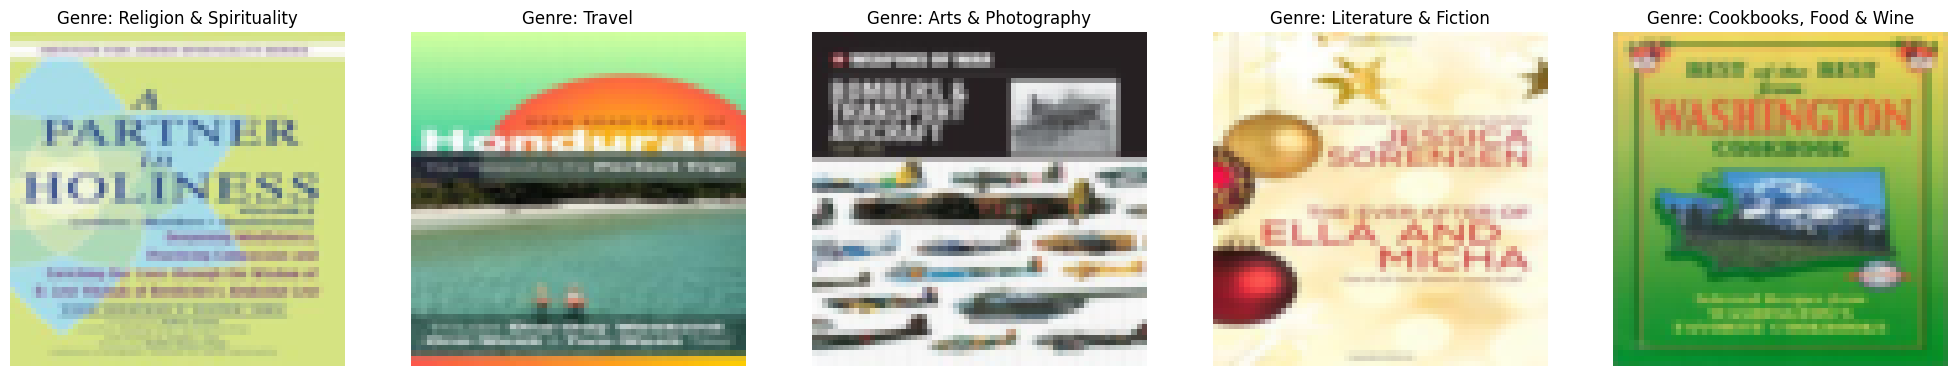

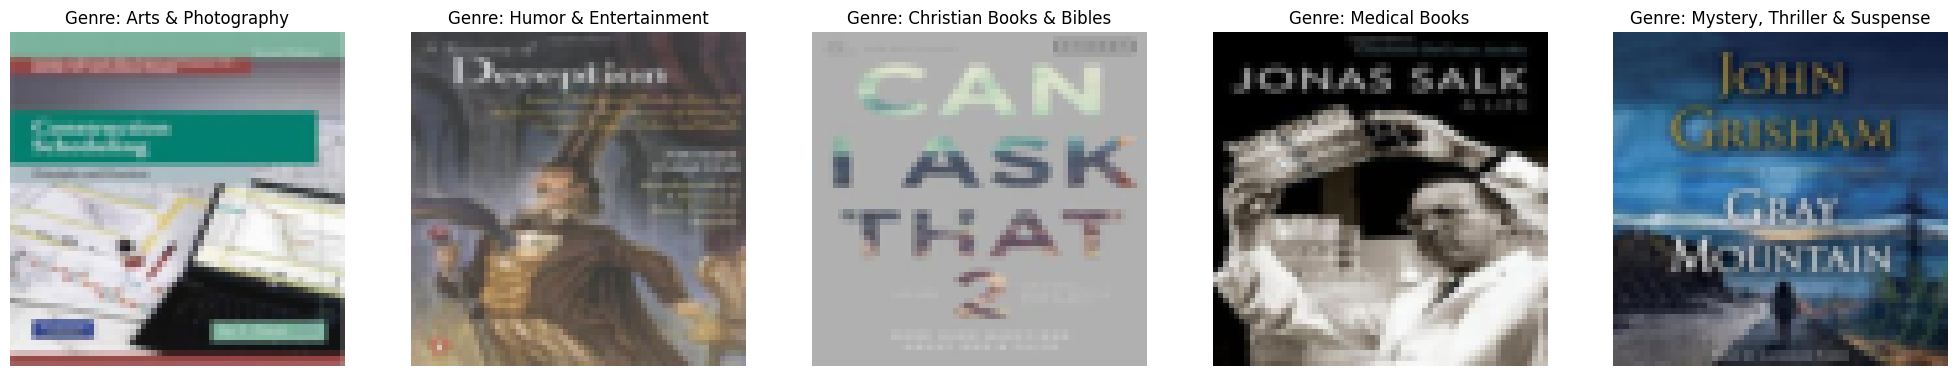

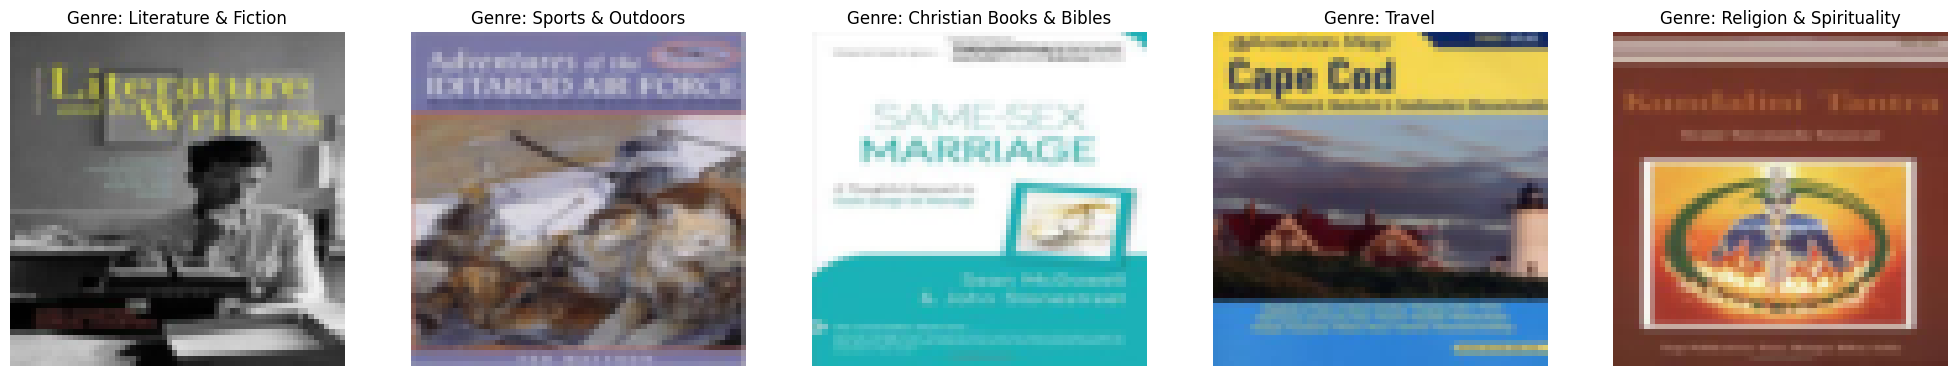

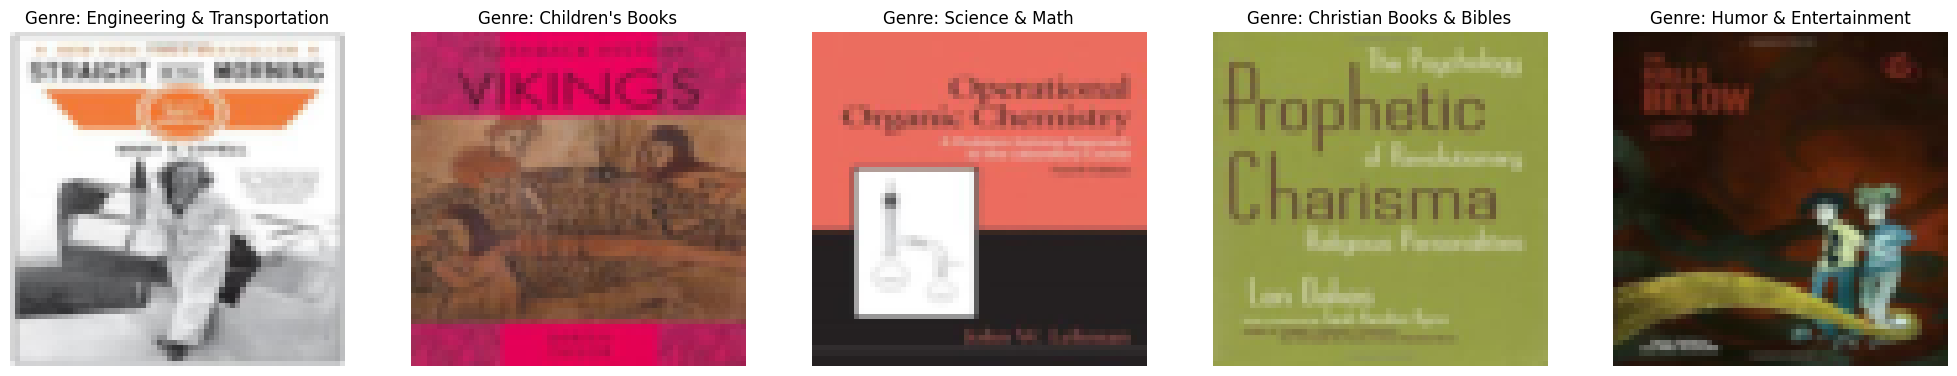

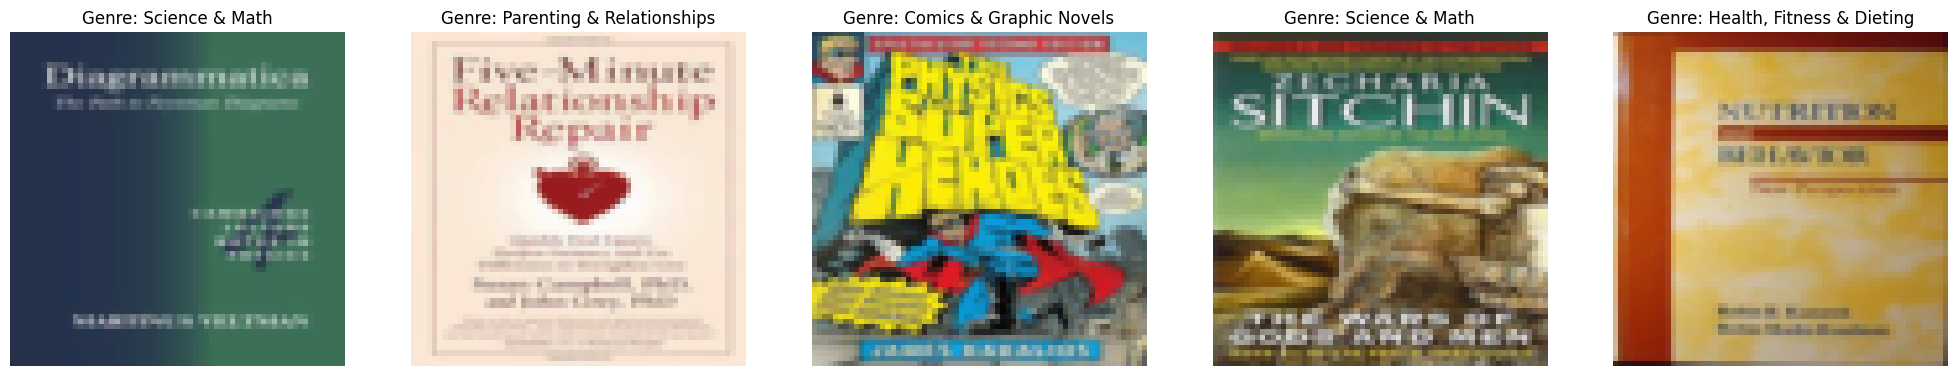

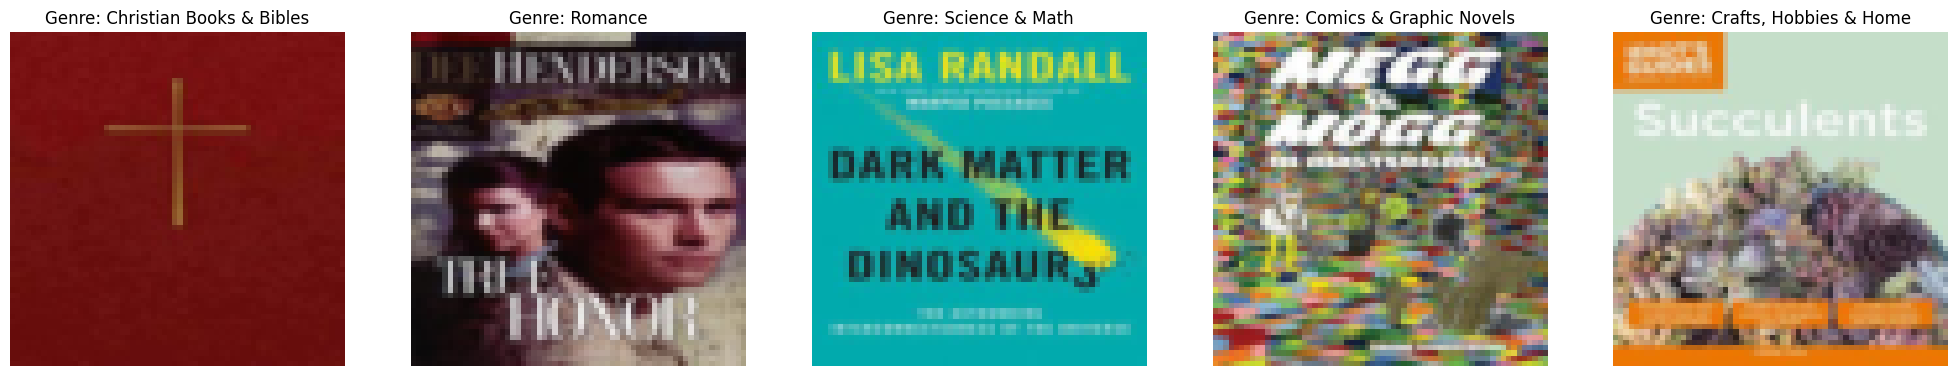

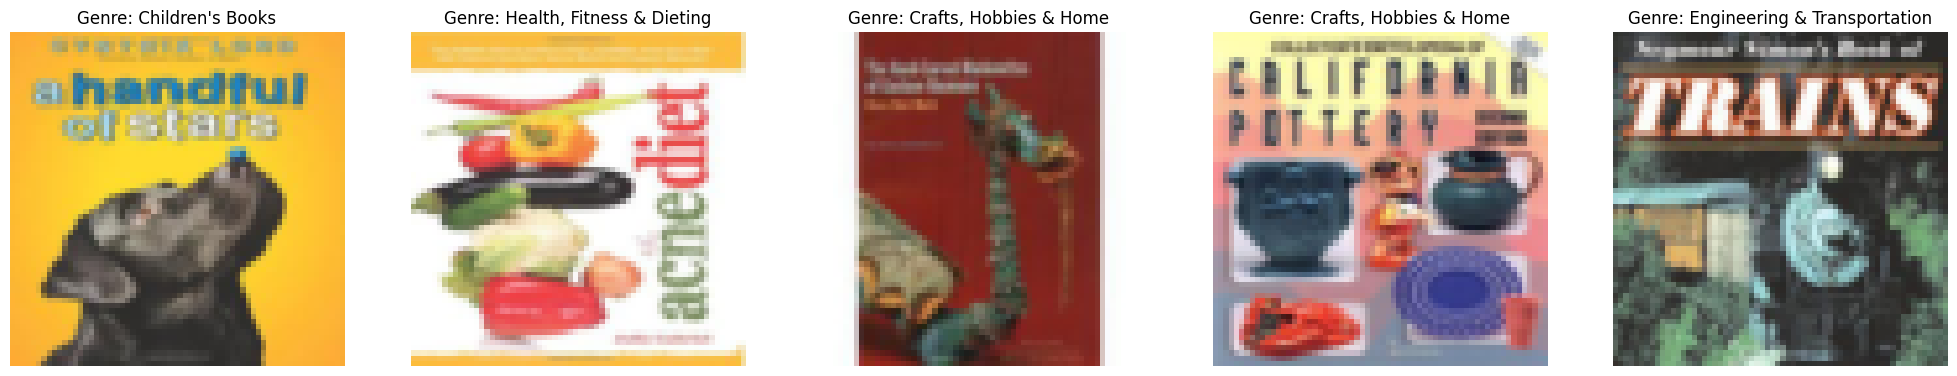

In [ ]:
for i in range(1, 10):
    plot_images(test_librosData, indexes=[1*i, 101*i, 201*i, 301*i, 401*i])

Por último definimos una función que nos devuelva la cantidad de imágenes que hay para cada género, y mostramos estos datos por pantalla para el dataset de entrenamiento:

In [ ]:
def images_for_genre(dataset):
    genre_name = []
    cant_images = []
    for genre in dataset.genres:
        genre_name.append(genre)
        cant_images.append(len(dataset.data.loc[dataset.data['Category'] == genre]))
    return genre_name, cant_images

cant_images_for_genre = {genre: cant_images for genre, cant_images in zip(*images_for_genre(train_librosData))}

for genre, cant in cant_images_for_genre.items():
    print(f"Género: {genre} - Cantidad de imágenes: {cant}")

Género: Arts & Photography - Cantidad de imágenes: 1710
Género: Biographies & Memoirs - Cantidad de imágenes: 1710
Género: Business & Money - Cantidad de imágenes: 1710
Género: Calendars - Cantidad de imágenes: 1710
Género: Children's Books - Cantidad de imágenes: 1710
Género: Christian Books & Bibles - Cantidad de imágenes: 1710
Género: Comics & Graphic Novels - Cantidad de imágenes: 1710
Género: Computers & Technology - Cantidad de imágenes: 1710
Género: Cookbooks, Food & Wine - Cantidad de imágenes: 1710
Género: Crafts, Hobbies & Home - Cantidad de imágenes: 1710
Género: Engineering & Transportation - Cantidad de imágenes: 1710
Género: Health, Fitness & Dieting - Cantidad de imágenes: 1710
Género: History - Cantidad de imágenes: 1710
Género: Humor & Entertainment - Cantidad de imágenes: 1710
Género: Law - Cantidad de imágenes: 1710
Género: Literature & Fiction - Cantidad de imágenes: 1710
Género: Medical Books - Cantidad de imágenes: 1710
Género: Mystery, Thriller & Suspense - Canti

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


.